Importing Libraries

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from collections import deque
from copy import deepcopy
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import HTML
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print("Using device:", device)
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))


True
Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [2]:
def to_device(tensor):
    return tensor.to(device)

Class for connect4 environment

In [3]:
class Connect4Env:
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.last_move = None
        return self._get_obs()

    def _get_obs(self):
        p1_board = (self.board == 1).astype(np.float32)
        p2_board = (self.board == -1).astype(np.float32)
        return np.stack([p1_board, p2_board], axis=0) if self.current_player == 1 else np.stack([p2_board, p1_board], axis=0)

    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if action not in self.valid_actions():
            return self._get_obs(), -10, True, {}

        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        if self._check_winner(self.current_player, self.last_move):
            return self._get_obs(), 10, True, {}

        if len(self.valid_actions()) == 0:
            return self._get_obs(), 0, True, {}

        self.current_player *= -1
        return self._get_obs(), 0, False, {}

    def _check_winner(self, player, last_move):
        if last_move is None:
            return False
        r, c = last_move
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for d in [-1, 1]:
                nr, nc = r + d * dr, c + d * dc
                while 0 <= nr < self.rows and 0 <= nc < self.cols and self.board[nr, nc] == player:
                    count += 1
                    if count >= 4:
                        return True
                    nr += d * dr
                    nc += d * dc
        return False

    @staticmethod
    def _check_winner_static(board, player):
        for r in range(6):
            for c in range(4):
                if all(board[r, c+i] == player for i in range(4)):
                    return True
        for c in range(7):
            for r in range(3):
                if all(board[r+i, c] == player for i in range(4)):
                    return True
        for r in range(3):
            for c in range(4):
                if all(board[r+i, c+i] == player for i in range(4)):
                    return True
        for r in range(3):
            for c in range(3, 7):
                if all(board[r+i, c-i] == player for i in range(4)):
                    return True
        return False



In [4]:
def find_threats_from_move(board, player, move):
    r, c = move
    rows, cols = 6, 7
    threats = set()
    directions = [(0,1), (1,0), (1,1), (1,-1)]

    for dr, dc in directions:
        for offset in range(-3, 1):
            segment = []
            positions = []
            for i in range(4):
                nr = r + (offset + i) * dr
                nc = c + (offset + i) * dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    segment.append(board[nr, nc])
                    positions.append((nr, nc))
            if len(segment) == 4 and segment.count(player) == 3 and segment.count(0) == 1:
                idx = segment.index(0)
                er, ec = positions[idx]
                if er == rows - 1 or board[er + 1, ec] != 0:
                    threats.add(ec)
    return threats

In [5]:
def analyze_move(prev_board, new_board, current_player, valid_actions, last_move):
    reward = 0.0

    threats = find_threats_from_move(new_board, current_player, last_move)
    if len(threats) >= 2:
        reward += 0.6
    elif len(threats) == 1:
        reward += 0.3

    for action in valid_actions:
        temp = new_board.copy()
        for r in range(5, -1, -1):
            if temp[r, action] == 0:
                temp[r, action] = current_player
                break
        if Connect4Env._check_winner_static(temp, current_player):
            reward -= 3
            break

    opponent = -current_player
    blocked = False
    for action in valid_actions:
        temp = prev_board.copy()
        for r in range(5, -1, -1):
            if temp[r, action] == 0:
                temp[r, action] = opponent
                break
        if Connect4Env._check_winner_static(temp, opponent):
            temp2 = new_board.copy()
            for r in range(5, -1, -1):
                if temp2[r, action] == 0:
                    temp2[r, action] = opponent
                    break
            if not Connect4Env._check_winner_static(temp2, opponent):
                reward += 3
                blocked = True
                break
    if not blocked:
        reward -= 0.2

    return reward

In [6]:
def count_true_threes(board, player):
    count = 0
    # Horizontal
    for row in range(6):
        for col in range(4):
            line = board[row, col:col+4]
            if np.count_nonzero(line == player) == 3 and np.count_nonzero(line == 0) == 1:
                if is_contiguous(line, player):
                    count += 1
    # Vertical
    for col in range(7):
        for row in range(3):
            line = board[row:row+4, col]
            if np.count_nonzero(line == player) == 3 and np.count_nonzero(line == 0) == 1:
                if is_contiguous(line, player):
                    count += 1
    # Diagonal (\)
    for row in range(3):
        for col in range(4):
            line = [board[row+i, col+i] for i in range(4)]
            if line.count(player) == 3 and line.count(0) == 1:
                if is_contiguous(line, player):
                    count += 1
    # Diagonal (/)
    for row in range(3):
        for col in range(3, 7):
            line = [board[row+i, col-i] for i in range(4)]
            if line.count(player) == 3 and line.count(0) == 1:
                if is_contiguous(line, player):
                    count += 1
    return count

def is_contiguous(line, player):
    # True if there are no gaps between player pieces in the 4-element line
    indexes = [i for i, val in enumerate(line) if val == player]
    return max(indexes) - min(indexes) <= 2

Model

In [7]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers to capture spatial patterns
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Added pooling to reduce the dimensionality
        )

        # Fully connected layer for decision making
        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 4, 64),  # Adjusted for MaxPool2d
            nn.ReLU(),
            nn.Linear(64, 7)
        )

        # Weight initialization
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, valid_moves_mask=None):
        x = self.conv_layers(x)
        x = x.flatten(1)
        x = self.fc(x)

        if valid_moves_mask is not None:
            x = x.masked_fill(~valid_moves_mask, float('-inf'))
        return x

Replay Buffer

In [8]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha

    def push(self, transition, error):
        self.buffer.append(transition)
        self.priorities.append((abs(error) + 1e-5) ** self.alpha)

    def sample(self, batch_size):
        total_priority = sum(self.priorities)
        probabilities = [p / total_priority for p in self.priorities]
        indices = random.choices(range(len(self.buffer)), k=batch_size, weights=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        return samples

    def __len__(self):
        return len(self.buffer)

In [9]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


Selecting Action

In [10]:
# --- Training Functions ---
def select_action(model, state, epsilon, valid_actions):
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).view(1, 2, 6, 7).to(device)
            q_values = model(state_tensor).squeeze()
            q_values[[i for i in range(7) if i not in valid_actions]] = -float('inf')
            return torch.argmax(q_values).item()

In [11]:
def plot_training_metrics(metrics):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    axes[0, 0].plot(metrics['episode_rewards_p1'], label='Player 1')
    axes[0, 0].plot(metrics['episode_rewards_p2'], label='Player 2')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].legend()

    axes[0, 1].plot(metrics['epsilon_values'])
    axes[0, 1].set_title('Epsilon')

    if len(metrics['losses']) > 0:
        window = min(100, len(metrics['losses']))
        smooth = np.convolve(metrics['losses'], np.ones(window)/window, mode='valid')
        axes[1, 0].plot(smooth)
        axes[1, 0].set_title('Loss')

    if len(metrics['win_ratio']) > 0:
        axes[1, 1].plot(metrics['win_ratio'])
        axes[1, 1].set_title('Win Ratio')

    norm_usage = metrics['column_usage'] / np.sum(metrics['column_usage'])
    axes[2, 0].bar(range(len(norm_usage)), norm_usage)
    axes[2, 0].set_title('Column Usage')

    if len(metrics['avg_game_length']) > 0:
        window = min(100, len(metrics['avg_game_length']))
        smooth = np.convolve(metrics['avg_game_length'], np.ones(window)/window, mode='valid')
        axes[2, 1].plot(smooth)
        axes[2, 1].set_title('Avg Game Length')

    plt.tight_layout()
    plt.show()

Training Loop

In [21]:
metrics = {
        'episode_rewards_p1': [], 'episode_rewards_p2': [], 'epsilon_values': [],
        'losses': [], 'p1_wins': 0, 'p2_wins': 0, 'draws': 0, 'win_ratio': [],
        'column_usage': np.zeros(7), 'avg_game_length': []
    }
def train_self_play(episodes=50000, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995,
                    gamma=0.99, batch_size=64, update_target_every=10):
    env = Connect4Env()
    model1 = DQN().to(device)
    model2 = DQN().to(device)

    target_model1 = DQN().to(device)
    target_model2 = DQN().to(device)

    target_model1.load_state_dict(model1.state_dict())
    target_model2.load_state_dict(model2.state_dict())

    optimizer1 = optim.Adam(model1.parameters(), lr=5e-4) 
    optimizer2 = optim.Adam(model2.parameters(), lr=5e-4)

    buffer1 = PrioritizedReplayBuffer()
    buffer2 = PrioritizedReplayBuffer()

    for episode in range(episodes):
        game_length = 0
        state = env.reset()
        done = False
        reward_p1 = 0
        reward_p2 = 0
        last_moves = {1: None, -1: None}

        while not done:
            game_length += 1
            current_player = env.current_player
            model = model1 if current_player == 1 else model2
            buffer = buffer1 if current_player == 1 else buffer2
            optimizer = optimizer1 if current_player == 1 else optimizer2
            target_model = target_model1 if current_player == 1 else target_model2

            valid_actions = env.valid_actions()
            action = select_action(model, state, epsilon, valid_actions)

            prev_board = env.board.copy()
            next_state, reward, done, _ = env.step(action)
            reward += analyze_move(prev_board, env.board, current_player, env.valid_actions(), env.last_move)

            # Calculate TD Error for Prioritized Replay
            error = abs(reward + gamma * torch.max(target_model(torch.tensor(next_state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device)).detach()) - model(torch.tensor(state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device))[0, action])
            
            last_moves[current_player] = (np.array(state, copy=True), action, np.array(next_state, copy=True))
            
            buffer.push((np.array(state, copy=True), action, reward, np.array(next_state, copy=True), done), error)
            state = next_state

            metrics['column_usage'][action] += 1

            if current_player == 1:
                reward_p1 += reward
            else:
                reward_p2 += reward

            if done and reward >= 1:
                losing_player = -current_player
                if last_moves[losing_player] is not None:
                    s, a, ns = last_moves[losing_player]
                    opp_buffer = buffer1 if losing_player == 1 else buffer2
                    error = abs(-1.0 + gamma * torch.max(target_model(torch.tensor(ns, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device)).detach()) - model(torch.tensor(s, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device))[0, a])
                    opp_buffer.push((s, a, -10, ns, True),error)
                    if losing_player == 1:
                        reward_p1 += -10
                    else:
                        reward_p2 += -10

            if len(buffer) >= batch_size:
                transitions = buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*transitions)
                states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
                actions = torch.tensor(actions).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards).unsqueeze(1).to(device)
                next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                q_values = model(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q = target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards + gamma * max_next_q * (1 - dones)

                loss = F.mse_loss(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                metrics['losses'].append(loss.item())

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % update_target_every == 0:
            target_model1.load_state_dict(model1.state_dict())
            target_model2.load_state_dict(model2.state_dict())

        if episode % 100 == 0:
            metrics['win_ratio'].append(metrics['p1_wins'] / (episode + 1))
            print(f"Episode {episode}, P1 reward: {reward_p1:.2f}, P2 reward: {reward_p2:.2f}, Epsilon: {epsilon:.3f}")
            # --- Print a sample game between models ---
            temp_env = Connect4Env()
            game_state = temp_env.reset()
            game_over = False
            print("\nSample Game:")
            while not game_over:
                player = temp_env.current_player
                model = model1 if player == 1 else model2
                valid_actions = temp_env.valid_actions()
                action = select_action(model, game_state, 0.0, valid_actions)
                game_state, _, game_over, _ = temp_env.step(action)
                print(temp_env.board)
                print("Player", player, "chose column", action)
                print("---")

        if episode % 10000 == 0:
            torch.save(model1.state_dict(), f"connect4_model1_{episode}.pth")
            torch.save(model2.state_dict(), f"connect4_model2_{episode}.pth")

        metrics['episode_rewards_p1'].append(reward_p1)
        metrics['episode_rewards_p2'].append(reward_p2)
        metrics['epsilon_values'].append(epsilon)
        metrics['avg_game_length'].append(game_length)
        if reward_p1 > reward_p2:
            metrics['p1_wins'] += 1
        elif reward_p2 > reward_p1:
            metrics['p2_wins'] += 1
        else:
            metrics['draws'] += 1

    torch.save(model1.state_dict(), "connect4_model1_final.pth")
    torch.save(model2.state_dict(), "connect4_model2_final.pth")
    return model1, model2


Train It

In [23]:
trained_model1, trained_model2 = train_self_play(episodes=100000,epsilon_decay=0.9999,epsilon_min=0.05,batch_size=64)
plot_training_metrics(metrics)

Episode 0, P1 reward: -9.30, P2 reward: -8.80, Epsilon: 1.000

Sample Game:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
Player 1 chose column 0
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1 -1  0  0  0  0  0]]
Player -1 chose column 1
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 1 -1  0  0  0  1  0]]
Player 1 chose column 5
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 1 -1  0  0  0  1  0]]
Player -1 chose column 1
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0]
 [ 1 -1  0  0  0  1  0]]
Player 1 chose column 1
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 

KeyboardInterrupt: 

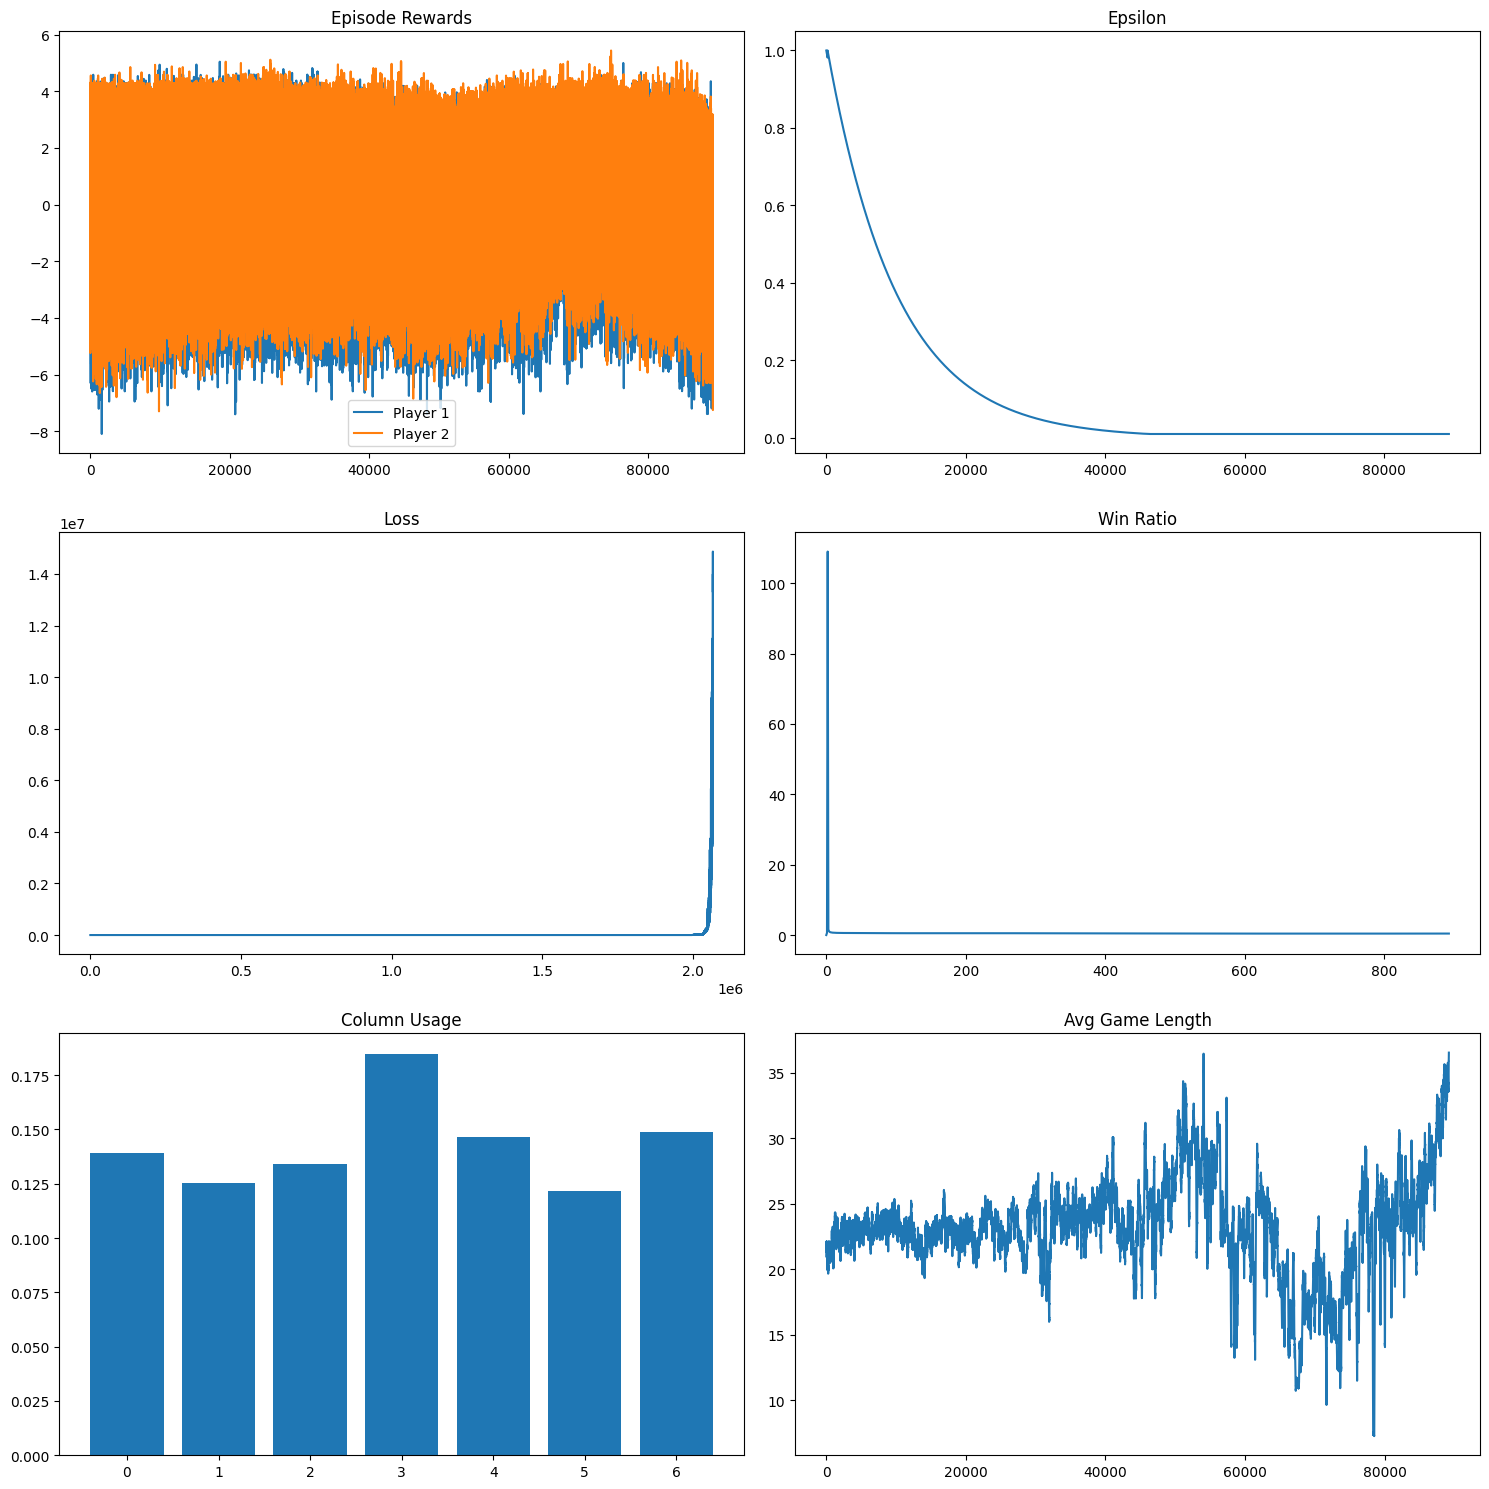

In [18]:
plot_training_metrics(metrics)

In [13]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [15]:
save_model(trained_model)

NameError: name 'trained_model' is not defined

Load Weights

In [21]:
def load_trained_model(path="connect4_model_weights.pth"):
    model = DQN().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  # Set to evaluation mode
    print(f"Loaded model from {path}")
    return model

In [11]:
trained_model = load_trained_model(path="connect4_dqn_ep10000.pth")

Loaded model from connect4_dqn_ep10000.pth


In [17]:
class Connect4UI:
    def __init__(self, model_p1, model_p2, ai_player=-1):
        # Initialize the game environment
        self.env = Connect4Env()
        self.model_p1 = model_p1  # Model for player 1 (X)
        self.model_p2 = model_p2  # Model for player -1 (O)
        self.ai_player = ai_player  # -1 means AI plays as O, 1 means AI plays as X
        self.model = self.model_p2 if ai_player == -1 else self.model_p1  # Current model

        # Create UI elements
        self.create_ui()

        # Set correct initial state
        self.initialize_game_state()

    def initialize_game_state(self):
        """Initialize the game state based on who starts first"""
        # Reset game
        self.state = self.env.reset()
        self.done = False

        # Update display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def create_ui(self):
        # Title
        self.title = widgets.HTML(value="<h1 style='text-align: center;'>Connect 4</h1>")

        # Status message
        self.status = widgets.HTML(value="<h3 style='text-align: center;'>Game ready! Make your move</h3>")

        # Create buttons for each column
        self.buttons = []
        for col in range(7):
            btn = widgets.Button(description=str(col),
                                layout=widgets.Layout(width='60px', height='40px'))
            btn.on_click(lambda b, col=col: self.make_move(col))
            self.buttons.append(btn)

        # Button container (top row)
        self.button_container = widgets.HBox(self.buttons,
                                           layout=widgets.Layout(justify_content='center'))

        # Game board display
        self.board_display = widgets.HTML(value=self.render_board_html())

        # Add Read Board button
        self.read_board_button = widgets.Button(
            description="Read Board",
            button_style='info',
            layout=widgets.Layout(width='150px')
        )
        self.read_board_button.on_click(self.read_board_aloud)
        
        # Who starts selector
        self.player_options = [('You start (X)', 1), ('AI starts (O)', -1)]
        self.player_starter = widgets.RadioButtons(
            options=self.player_options,
            value=-1,  # Default to AI starting
            description='New Game:',
            layout=widgets.Layout(width='300px')
        )

        # New Game button
        self.new_game_button = widgets.Button(
            description="Start New Game",
            button_style='primary',
            layout=widgets.Layout(width='150px')
        )
        self.new_game_button.on_click(self.start_new_game)

        # Game controls
        self.game_controls = widgets.HBox([
            self.player_starter,
            self.new_game_button,
            self.read_board_button  # Add the Read Board button to the controls
        ], layout=widgets.Layout(justify_content='center', margin='20px 0'))

        # Add file upload widget for voice commands
        self.file_upload = widgets.FileUpload(
            accept='',  # Accept all file types
            multiple=False,  # Only allow single file upload
            description='Voice Command:',
            layout=widgets.Layout(width='250px')
        )
        self.file_upload.observe(self.handle_file_upload, names='value')

        # Add submit button for processing the uploaded file
        self.submit_button = widgets.Button(
            description="Process Command",
            button_style='success',
            layout=widgets.Layout(width='150px')
        )
        self.submit_button.on_click(self.process_audio_command)

        # Audio controls
        self.audio_controls = widgets.HBox([
            self.file_upload,
            self.submit_button
        ], layout=widgets.Layout(justify_content='center', margin='10px 0'))

        # Add upload status indicator
        self.upload_status = widgets.HTML(value="<p>No file uploaded</p>")

        # Add status for speech synthesis
        self.speech_status = widgets.HTML(value="")

        # Combine all widgets
        self.app = widgets.VBox([
            self.title,
            self.status,
            self.button_container,
            self.board_display,
            self.game_controls,
            self.audio_controls,
            self.upload_status,
            self.speech_status
        ], layout=widgets.Layout(width='100%', align_items='center'))

        # Display the UI
        display(self.app)
        
        # Add JavaScript for text-to-speech functionality
        display(HTML("""
        <script>
        function speakText(text) {
            if ('speechSynthesis' in window) {
                const utterance = new SpeechSynthesisUtterance(text);
                utterance.rate = 1.0;  // Speech rate
                utterance.pitch = 1.0; // Speech pitch
                window.speechSynthesis.cancel(); // Cancel any ongoing speech
                window.speechSynthesis.speak(utterance);
                return "Speaking...";
            } else {
                return "Text-to-speech not supported in this browser.";
            }
        }
        
        // Make the function available to Python
        window.speakText = speakText;
        </script>
        """))

    def read_board_aloud(self, _=None):
        """Convert board state to spoken text and read it aloud"""
        board_text = self.generate_board_description()
        
        # Use JavaScript to speak the text
        js_code = f"""
        var result = "";
        if (typeof window.speakText === 'function') {{
            result = window.speakText("{board_text}");
        }} else {{
            result = "Text-to-speech function not available.";
        }}
        result;
        """
        
        # Execute the JavaScript to speak the text
        try:
            from IPython.display import Javascript
            display(Javascript(js_code))
            self.speech_status.value = "<p>Reading board state aloud...</p>"
            
            # Clear the status after 3 seconds
            def clear_status():
                time.sleep(3)
                self.speech_status.value = ""
            
            import threading
            threading.Thread(target=clear_status).start()
            
        except Exception as e:
            self.speech_status.value = f"<p style='color:red;'>Error with text-to-speech: {str(e)}</p>"

    def generate_board_description(self):
        """Generate a textual description of the board state"""
        # Escape quotes for JavaScript
        board = self.env.board
        rows, cols = board.shape
        
        # Start with the game status
        if hasattr(self, 'done') and self.done:
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0
                
            if winner == 1:
                status = "Player X has won. " if self.ai_player == -1 else "AI has won. "
            elif winner == -1:
                status = "AI has won. " if self.ai_player == -1 else "Player X has won. "
            else:
                status = "The game is a draw. "
        else:
            human_player = -self.ai_player
            if self.env.current_player == human_player:
                player_name = "Your"
                player_symbol = "X" if human_player == 1 else "O"
            else:
                player_name = "AI's"
                player_symbol = "X" if self.ai_player == 1 else "O"
                
            status = f"It is {player_name} turn with {player_symbol}. "
        
        # Describe the board
        board_desc = "Board state: "
        
        # Count pieces by column
        for col in range(cols):
            pieces = []
            for row in range(rows-1, -1, -1):  # Start from bottom row
                if board[row, col] == 1:
                    pieces.append("X")
                elif board[row, col] == -1:
                    pieces.append("O")
            
            if pieces:
                board_desc += f"Column {col} has {len(pieces)} pieces: {', '.join(pieces)} from bottom to top. "
            else:
                board_desc += f"Column {col} is empty. "
        
        # Escape quotes and special characters
        full_description = status + board_desc
        full_description = full_description.replace('"', '\\"').replace("'", "\\'")
        
        return full_description

    def handle_file_upload(self, change):
        """Handle file upload event"""
        if change['new']:
            try:
                # Check if change['new'] is a tuple or a dictionary
                if isinstance(change['new'], tuple):
                    # If it's a tuple, extract the first element
                    uploaded_file = change['new'][0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded_file = next(iter(change['new'].values()))
                
                # Check if 'metadata' exists in the structure
                if 'metadata' in uploaded_file and 'name' in uploaded_file['metadata']:
                    filename = uploaded_file['metadata']['name']
                    # Just acknowledge the upload
                    self.upload_status.value = f"<p>File uploaded: {filename}</p>"
                else:
                    # Handle case where metadata or name is missing
                    self.upload_status.value = f"<p>File uploaded successfully</p>"
                
                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"
            except Exception as e:
                # Fallback for any unexpected structure
                self.upload_status.value = f"<p>File uploaded, but couldn't read file details: {str(e)}</p>"
                self.upload_status.value += f"<p>Click 'Process Command' to execute the command.</p>"

    def process_audio_command(self, _=None):
        """Process an uploaded audio file and dispatch the spoken command."""
        try:
            # ── 1. Validate upload ────────────────────────────────────────────────
            if not self.file_upload.value:
                self.upload_status.value = (
                    "<p style='color:orange;'>Please upload an audio file first.</p>"
                )
                return

            try:
                # Check if file_upload.value is a tuple or a dictionary
                if isinstance(self.file_upload.value, tuple):
                    # If it's a tuple, extract the first element
                    uploaded = self.file_upload.value[0]
                else:
                    # If it's a dictionary, use the original code
                    uploaded = next(iter(self.file_upload.value.values()))
                
                # Check if 'content' exists
                if 'content' not in uploaded:
                    self.upload_status.value = (
                        "<p style='color:red;'>Invalid file format: missing content</p>"
                    )
                    return
                    
                raw_bytes = uploaded["content"]
                
                # Try to get filename but provide default if not available
                fname = "uploaded_audio"
                if 'metadata' in uploaded and 'name' in uploaded['metadata']:
                    fname = uploaded['metadata']['name']
            except Exception as e:
                self.upload_status.value = (
                    f"<p style='color:red;'>Error reading file: {str(e)}</p>"
                )
                return

            self.upload_status.value = "<p style='color:blue;'>Processing audio file...</p>"

            # You need to import these libraries in your notebook
            # If these imports are failing, install the libraries first:
            # !pip install SpeechRecognition pydub
            try:
                import speech_recognition as sr
                from pydub import AudioSegment
            except ImportError as e:
                self.upload_status.value = (
                    "<p style='color:red;'>Missing required Python libraries. Please run the following in a cell:</p>"
                    "<pre>!pip install SpeechRecognition pydub</pre>"
                )
                return

            # ── 2. Convert to mono-WAV in-memory (handles mp3, wav, m4a, etc.) ────
            try:
                # This will fail if ffmpeg/ffprobe is not installed
                audio = AudioSegment.from_file(io.BytesIO(raw_bytes))
                audio = audio.set_frame_rate(16_000).set_channels(1)
                with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as wav_tmp:
                    audio.export(wav_tmp.name, format="wav")
                    wav_path = wav_tmp.name
            except FileNotFoundError as err:
                if 'ffprobe' in str(err) or 'ffmpeg' in str(err):
                    self.upload_status.value = (
                        "<p style='color:red;'>Missing FFmpeg tools. This feature requires FFmpeg to be installed.</p>"
                        "<p>Please install FFmpeg by running the following command in a cell:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using Google Colab, run:</p>"
                        "<pre>!apt-get update && apt-get install -y ffmpeg</pre>"
                        "<p>If using a local environment, install FFmpeg using your package manager, e.g.:</p>"
                        "<p>- Ubuntu/Debian: <code>sudo apt install ffmpeg</code></p>"
                        "<p>- macOS: <code>brew install ffmpeg</code></p>"
                        "<p>- Windows: <a href='https://ffmpeg.org/download.html'>Download from ffmpeg.org</a></p>"
                    )
                else:
                    self.upload_status.value = (
                        f"<p style='color:red;'>Error: {str(err)}</p>"
                    )
                return
            except Exception as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Cannot process audio \"" + fname + "\": " + str(exc) + "</p>"
                )
                return

            # ── 3. Speech-to-text (Google Web API) ────────────────────────────────
            try:
                recog = sr.Recognizer()
                with sr.AudioFile(wav_path) as source:
                    # remove ambient-noise adjustment for prerecorded files
                    audio_data = recog.record(source)      # grab the whole file
                text = recog.recognize_google(audio_data, language='en-US').lower()
                self.upload_status.value = f"<p>Heard: \"{text}\"</p>"
            except sr.UnknownValueError:
                self.upload_status.value = (
                    "<p style='color:red;'>Sorry, I couldn't understand that.</p>"
                )
                return
            except sr.RequestError as exc:
                self.upload_status.value = (
                    "<p style='color:red;'>Speech-service error: " + str(exc) + "</p>"
                )
                return
            finally:
                # Clean temp file
                with suppress(FileNotFoundError):
                    os.remove(wav_path)

            # ── 4. Command routing ────────────────────────────────────────────────
            digit_words = {
                "zero": 0,
                "one": 1,
                "two": 2,
                "three": 3,
                "four": 4,
                "five": 5,
                "six": 6,
            }

            # Add handling for "read board" command
            if re.search(r"\bread\b.*\bboard\b", text):
                self.upload_status.value += "<p>Reading board state...</p>"
                self.read_board_aloud(None)
                return

            # new-game
            if re.search(r"\bnew\b.*\bgame\b", text):
                self.upload_status.value += "<p>Starting a new game!</p>"
                self.start_new_game(None)
                return

            # column n / just n
            # 1️⃣ match "column three", "col 3", "place in five" …
            col_match = re.search(r"\b(col(?:umn)?|place(?:\sin)?)\s*(\w+)", text)
            word_or_digit = None
            if col_match:
                word_or_digit = col_match.group(2)
            else:
                # 2️⃣ plain "three" / "3"
                word_or_digit = text.strip()

            # map to integer 0-6
            if word_or_digit in digit_words:
                col = digit_words[word_or_digit]
            elif word_or_digit.isdigit() and 0 <= int(word_or_digit) <= 6:
                col = int(word_or_digit)
            else:
                self.upload_status.value += (
                    "<p style='color:orange;'>Command not recognized. "
                    "Say e.g. \"column three\", \"new game\", or \"read board\".</p>"
                )
                return

            # ── 5. Execute move ───────────────────────────────────────────────────
            self.upload_status.value += f"<p>Placing piece in column {col}</p>"
            self.make_move(col)

            # ── 6. Reset uploader for next use ────────────────────────────────────
            try:
                if isinstance(self.file_upload.value, tuple):
                    self.file_upload.value = ()  # Clear tuple
                else:
                    self.file_upload.value.clear()  # Clear dictionary
            except Exception as e:
                # Just ignore errors in clearing
                pass

        except ImportError as e:
            self.upload_status.value = (
                "<p style='color:red;'>Missing required libraries: " + str(e) + ". "
                "Please install the required libraries using !pip install.</p>"
            )
        except Exception as e:
            self.upload_status.value = (
                "<p style='color:red;'>Error processing audio: " + str(e) + "</p>"
            )

    def start_new_game(self, b):
        """Start a new game with the selected starting player"""
        # Get who starts from the radio buttons
        selected_value = self.player_starter.value

        # Figure out who the AI player is based on selected value
        self.ai_player = -selected_value
        
        # Assign the right model based on which player the AI is
        self.model = self.model_p2 if self.ai_player == -1 else self.model_p1
        
        # Reset the game
        self.state = self.env.reset()
        self.done = False

        # Re-enable buttons
        for btn in self.buttons:
            btn.disabled = False

        # Update the display
        self.update_display()

        # If AI goes first, make its move
        if self.env.current_player == self.ai_player:
            time.sleep(0.5)
            self.make_ai_move()

    def render_board_html(self):
        """Render the Connect 4 board as HTML for display"""
        html = """
        <style>
        .board {
            background-color: #0052cc;
            display: inline-block;
            padding: 10px;
            border-radius: 10px;
        }
        .cell {
            width: 60px;
            height: 60px;
            background-color: #ffffff;
            border-radius: 50%;
            display: inline-block;
            margin: 5px;
        }
        .player1 {
            background-color: #ff0000;
        }
        .player-1 {
            background-color: #ffff00;
        }
        </style>
        <div class="board">
        """

        # Render each cell
        for row in range(self.env.rows):
            html += "<div>"
            for col in range(self.env.cols):
                cell_value = self.env.board[row, col]
                cell_class = f"cell player{cell_value}" if cell_value != 0 else "cell"
                html += f'<div class="{cell_class}"></div>'
            html += "</div>"

        html += "</div>"
        return html

    def update_display(self):
        """Update the board display and status message"""
        self.board_display.value = self.render_board_html()

        # Check game status
        reward = 0
        if hasattr(self, 'done') and self.done:
            # Game is over
            if self._check_winner(1):
                winner = 1
            elif self._check_winner(-1):
                winner = -1
            else:
                winner = 0  # Draw

            if winner == 1:
                message = "You win! 🎉" if self.ai_player == -1 else "AI wins! 🤖"
                color = "green" if self.ai_player == -1 else "red"
            elif winner == -1:
                message = "AI wins! 🤖" if self.ai_player == -1 else "You win! 🎉"
                color = "red" if self.ai_player == -1 else "green"
            else:
                message = "Draw game! 🤝"
                color = "blue"

            self.status.value = f"<h3 style='text-align: center; color: {color};'>{message}</h3>"

            # Disable column buttons
            for btn in self.buttons:
                btn.disabled = True
        else:
            # Game is ongoing
            current_player = self.env.current_player
            human_player = -self.ai_player

            if current_player == human_player:
                player_name = "Your"
                player_symbol = "(X)" if human_player == 1 else "(O)"
            else:
                player_name = "AI's"
                player_symbol = "(X)" if self.ai_player == 1 else "(O)"

            self.status.value = f"<h3 style='text-align: center;'>{player_name} turn {player_symbol}</h3>"

    def make_move(self, column):
        """Handle player's move on column click"""
        if hasattr(self, 'done') and self.done:
            # Game is already over
            return

        # Determine if it's human's turn
        human_player = -self.ai_player
        if self.env.current_player != human_player:
            self.status.value = "<h3 style='text-align: center; color: orange;'>Not your turn!</h3>"
            return

        # Check if move is valid
        if column not in self.env.valid_actions():
            self.status.value = "<h3 style='text-align: center; color: orange;'>Invalid move! Column is full</h3>"
            return

        # Make the move
        next_state, reward, done, _ = self.env.step(column)
        self.state = next_state
        self.done = done

        # Update the display
        self.update_display()

        # If game not over and AI's turn, make AI move
        if not done and self.env.current_player == self.ai_player:
            # Add a small delay for better UX
            time.sleep(0.5)
            self.make_ai_move()

    def make_ai_move(self):
        """Make an AI move using the trained model"""
        if hasattr(self, 'done') and self.done:
            return

        # Use select_action from the RL code
        valid_actions = self.env.valid_actions()
        # Fix the parameter order: model, state, epsilon, valid_actions
        action = select_action(self.model, self.state, epsilon=0.0, valid_actions=valid_actions)

        # Make the move
        next_state, reward, done, _ = self.env.step(action)
        self.state = next_state
        self.done = done

        # Update the display
        self.update_display()

    def _check_winner(self, player):
        """Check if given player has won by having 4 in a row anywhere on the board"""
        # Can only win if player is 1 (X) or -1 (O)
        if player == 0:
            return False
            
        board = self.env.board
        rows, cols = board.shape
    
        # Horizontal check
        for r in range(rows):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r, c+1] == player and 
                    board[r, c+2] == player and 
                    board[r, c+3] == player):
                    return True
        
        # Vertical check
        for r in range(rows - 3):
            for c in range(cols):
                if (board[r, c] == player and 
                    board[r+1, c] == player and 
                    board[r+2, c] == player and 
                    board[r+3, c] == player):
                    return True
        
        # Diagonal down-right
        for r in range(rows - 3):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r+1, c+1] == player and 
                    board[r+2, c+2] == player and 
                    board[r+3, c+3] == player):
                    return True
        
        # Diagonal up-right
        for r in range(3, rows):
            for c in range(cols - 3):
                if (board[r, c] == player and 
                    board[r-1, c+1] == player and 
                    board[r-2, c+2] == player and 
                    board[r-3, c+3] == player):
                    return True
        
        return False 
    
# Function to start the UI with a trained model
def start_connect4_ui(model_p1, model_p2, ai_player=-1):
    """
    Start the Connect4 UI with the trained model

    Args:
        model: The trained DQN model
        ai_starts: True if AI should start the game, False otherwise
    """
    ui = Connect4UI(model_p1, model_p2, ai_player=ai_player)
    return ui

Playing

In [26]:
def play_against_model(starting_player=None):
    model_choice = input("Play against model 1 (X) or model 2 (O)? Enter 1 or 2: ").strip()
    model_path = "connect4_model1_ep80000.pth" if model_choice == "1" else "connect4_model2_ep80000.pth"
    model = DQN().to(device)
    env = Connect4Env()

    model.load_state_dict(torch.load(model_path))
    model.eval()

    state = env.reset()
    done = False

    if starting_player is None:
        choice = input("Do you want to go first? (y/n): ").lower()
        if choice == 'y':
            env.current_player = -1
        else:
            env.current_player = 1
    else:
        env.current_player = -1 if starting_player == -1 else 1
    print("You are Player -1 (O). Model is Player 1 (X). Columns: 0 to 6")
    print(f"Playing against model from: {model_path}")
    print(env.board)

    while not done:
        if env.current_player == -1:
            try:
                user_action = int(input("Your move (0-6): "))
            except ValueError:
                print("Invalid input. Try a number from 0 to 6.")
                continue
            if user_action not in env.valid_actions():
                print("Invalid move. Try again.")
                continue
            state, reward, done, _ = env.step(user_action)
        else:
            valid_actions = env.valid_actions()
            action = select_action(model, state, epsilon=0.0, valid_actions=valid_actions)
            state, reward, done, _ = env.step(action)
            print("Model played column:", action)

        # Always print board after any move
        symbol_map = {1: 'X', -1: 'O', 0: '.'}
        print("\nCurrent board:")
        for row in env.board:
            print(' '.join(symbol_map[cell] for cell in row))
        print()

        if done:
            print("Game Over. Reward:", reward)
            break

In [23]:
def start_connect4_ui(model_p1, model_p2, ai_player=-1):
    ui = Connect4UI(model_p1, model_p2, ai_player)
    return ui

In [29]:
# Load trained models
model1 = DQN().to(device)
model2 = DQN().to(device)
model1.load_state_dict(torch.load("connect4_model1_80000.pth", map_location=device))
model2.load_state_dict(torch.load("connect4_model2_80000.pth", map_location=device))

# Start UI (AI plays as O by default)
start_connect4_ui(model1, model2, ai_player=-1)


C:\Users\ajmat\AppData\Local\Temp\ipykernel_95724\3842130334.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("connect4_model1_80000.pth

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>